In [7]:

import os
os.environ["TF_USE_LEGACY_KERAS"]="1"
from tf_keras import layers
from tf_keras import models
import importlib

In [6]:
from utils.load_dataset import load_dataset
import Entropy
importlib.reload(Entropy)
train_examples, validation_examples, num_examples, num_classes, class_names = load_dataset('horses_or_humans', 70)

INFO:absl:Load dataset info from C:\Users\neyen\tensorflow_datasets\horses_or_humans\3.0.0
INFO:absl:Creating a tf.data.Dataset reading 2 files located in folders: C:\Users\neyen\tensorflow_datasets\horses_or_humans\3.0.0.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\neyen\tensorflow_datasets\horses_or_humans\3.0.0.
INFO:absl:Constructing tf.data.Dataset horses_or_humans for split ('train[:70%]', 'train[70%:]'), from C:\Users\neyen\tensorflow_datasets\horses_or_humans\3.0.0


In [12]:
from utils.reformat_image import reformat_image
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_batches = train_examples.cache().shuffle(num_examples//4).map(reformat_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(reformat_image).batch(BATCH_SIZE).prefetch(1)
train_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

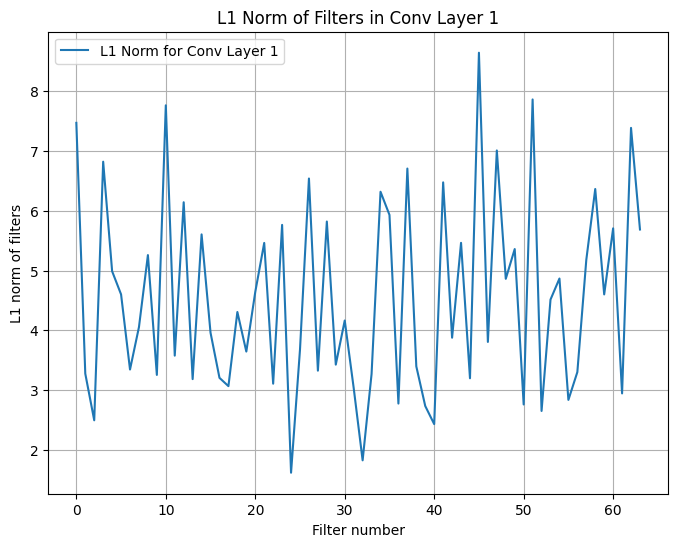

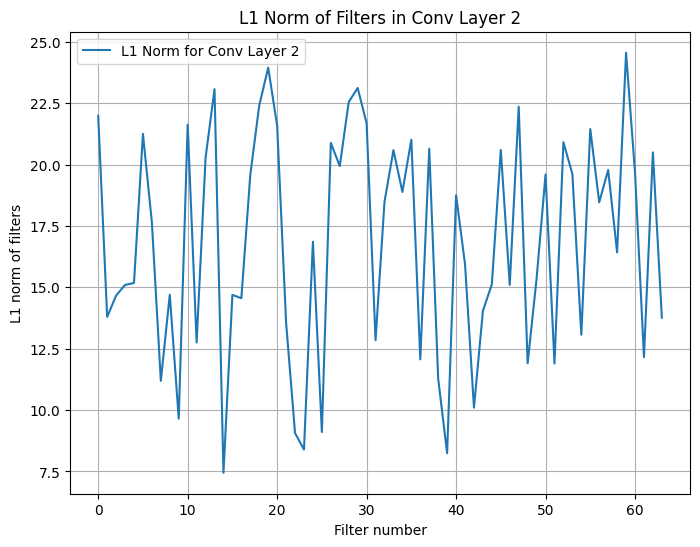

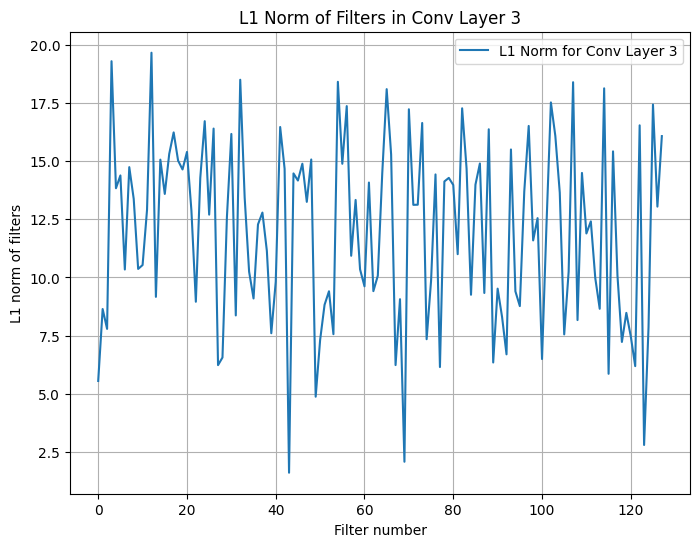

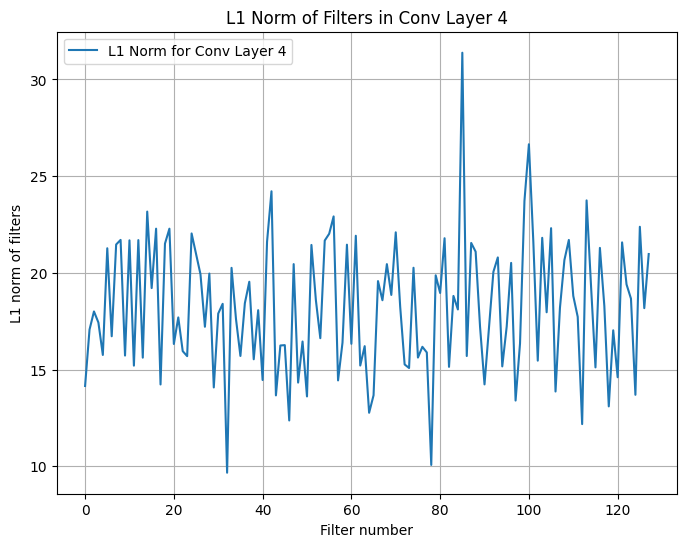

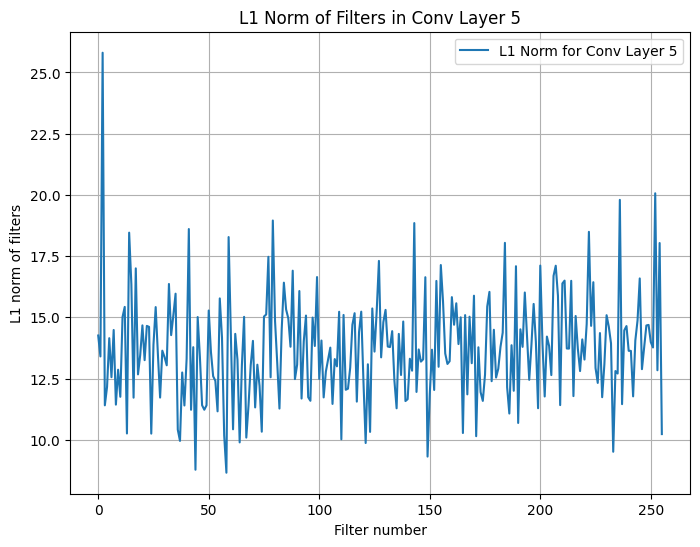

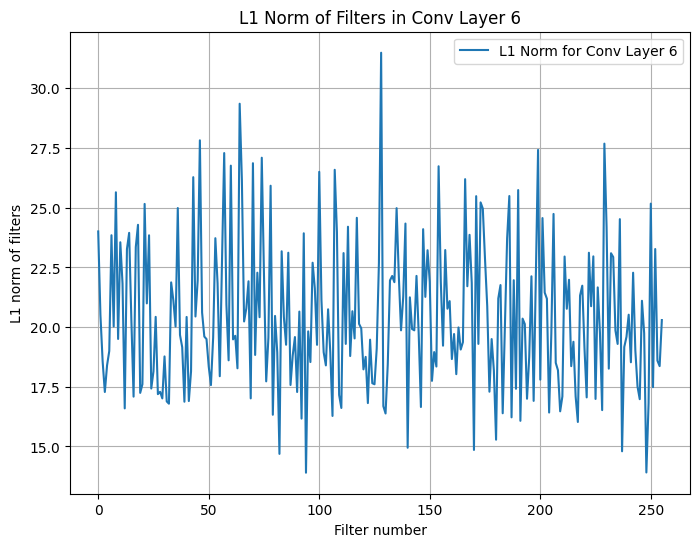

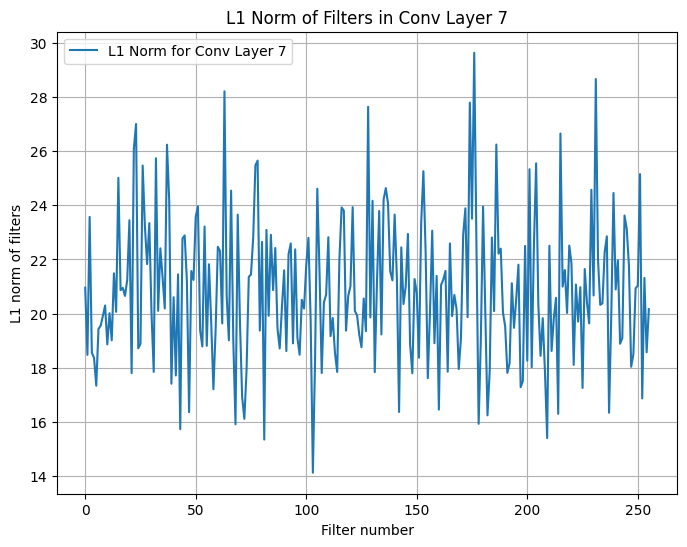

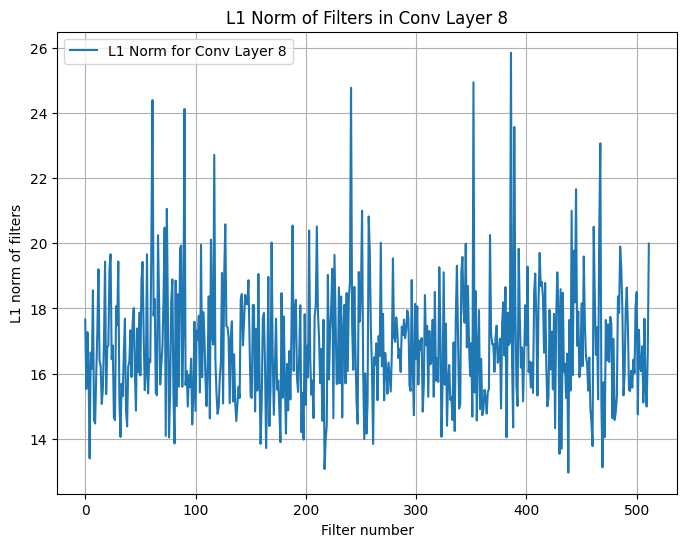

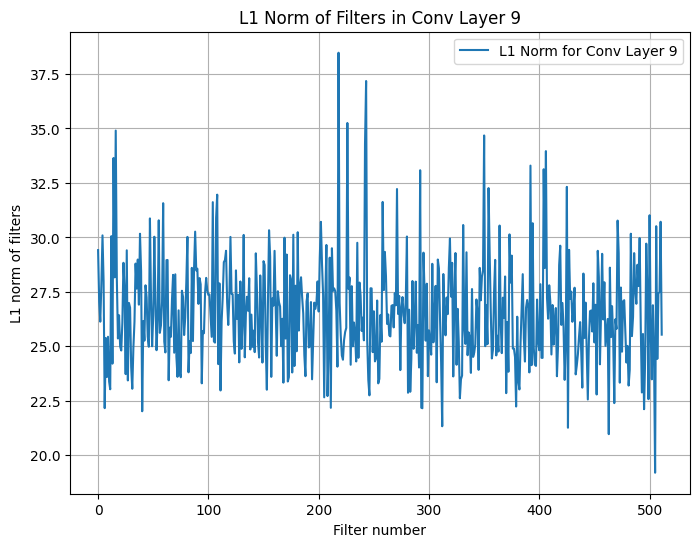

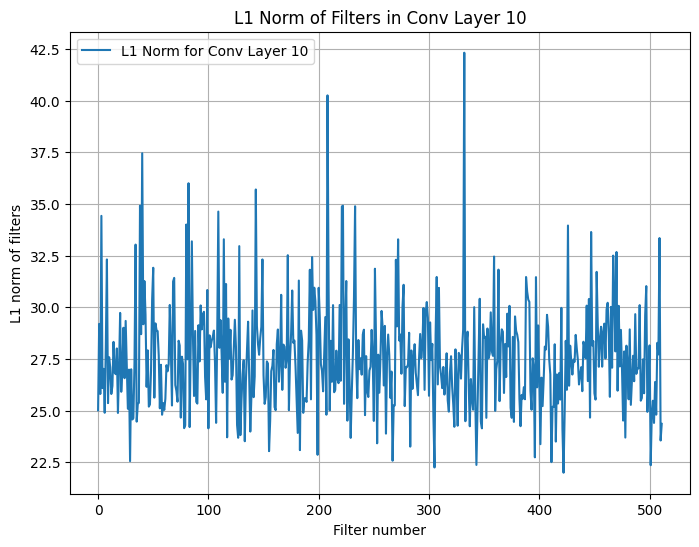

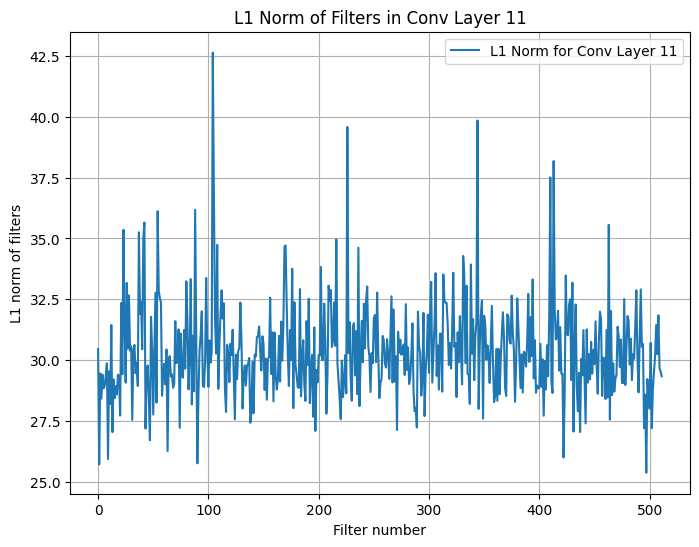

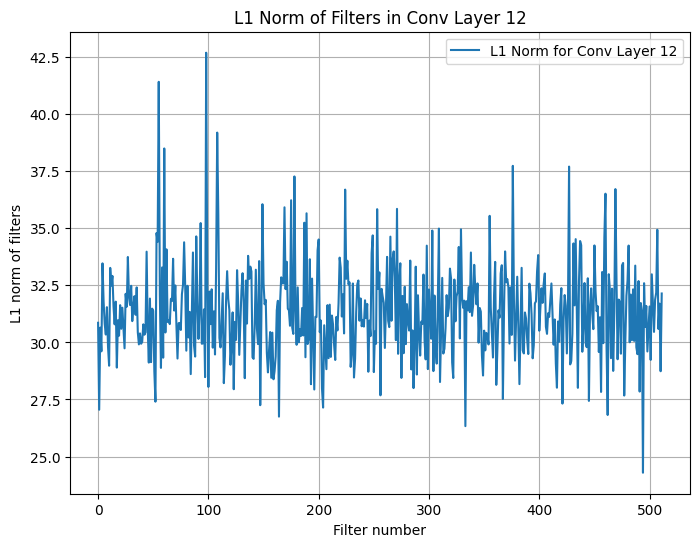

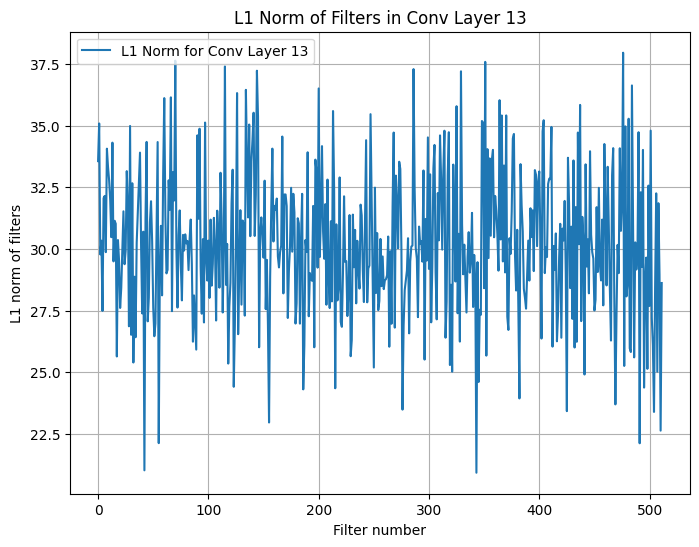

In [15]:
import matplotlib.pyplot as plt
import numpy as np

model = models.load_model("model_experiments/custom_vgg16.keras")
# Supposons que 'model' est ton modèle Keras déjà entraîné
# On va obtenir les poids des couches de convolution
conv_layer_weights = []
for i in range(len(model.layers)):
    if isinstance(model.layers[i], layers.Conv2D):  # Vérifie si la couche est une couche de convolution
        conv_layer_weights.append(model.layers[i].get_weights()[0])  # Récupère les poids de la couche

# Calcul de la norme L1 pour chaque filtre dans chaque couche de convolution
weights_dict = {}
for i, weight in enumerate(conv_layer_weights):
    num_filters = weight.shape[-1]  # Le nombre de filtres dans la couche
    weights_dict[f'Conv Layer {i+1}'] = []  # Créer une liste pour stocker les normes L1 des filtres

    for j in range(num_filters):
        filter_weights = weight[:, :, :, j]  # Poids du filtre j
        norm_l1 = np.sum(np.abs(filter_weights))  # Calcul de la norme L1 du filtre
        weights_dict[f'Conv Layer {i+1}'].append(norm_l1)

# Affichage des normes L1 de chaque filtre pour chaque couche de convolution
for i, (layer_name, norms) in enumerate(weights_dict.items()):
    plt.figure(figsize=(8, 6))
    plt.plot(norms, label=f'L1 Norm for {layer_name}')
    plt.xlabel('Filter number')
    plt.ylabel('L1 norm of filters')
    plt.title(f'L1 Norm of Filters in {layer_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


In [40]:
import L1_Norm_Pruning
importlib.reload(L1_Norm_Pruning)
from L1_Norm_Pruning import L1_Norm

testt_model = models.load_model("model_experiments/custom_vgg16.keras")
testt_model.summary()
pruning = L1_Norm(testt_model, 35)
pruningmodel = pruning.run()
pruningmodel.summary()

Model: "custom_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      